# NETWORK ANALYSIS

In [1]:
import networkx as nx
import pandas as pd
from fa2 import ForceAtlas2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### <font color="lightblue">Modelling the Network</font>

In [2]:
df_filepath = "Data/dataframe_characters.csv"
df = pd.read_csv(df_filepath)

In [3]:
df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

Each character is one row with a list of links to other characters. This we will expand into new rows for each relationship between the character and its links. This can be done using <code>df.explode()</code>

In [4]:
df_exploded = df.explode("Links")
df_exploded

,index,Category,Links,Seasons
0,Andy Bernard,Main_Characters,"['Erin Hannon', 'Angela Martin', 'Unnamed Cous...","[3, 4, 5, 6, 7, 8, 9]"
1,Angela Martin,Main_Characters,"['Dwight Schrute', 'Robert Lipton', 'Andy Bern...","[1, 2, 3, 4, 5, 6, 7, 8, 9]"
2,Clark Green,Main_Characters,"['Pete Miller', 'Kelly Kapoor', 'David Wallace...",[9]
3,Creed Bratton,Main_Characters,"['Creed Bratton', 'Michael Scott', 'Hannah Smo...","[1, 2, 3, 4, 5, 6, 7, 8, 9]"
4,Darryl Philbin,Main_Characters,"['Kelly Kapoor', 'Val Johnson', 'Jada Philbin'...","[1, 2, 3, 4, 5, 6, 7, 8, 9]"
...,...,...,...,...
289,Unnamed Cousin,Other,[],[]
290,Vikram,Other,[],[]
291,W.B. Jones,Other,"['Kevin Malone', 'Andy Bernard']",[]
292,Wally Amos,Other,[],[]


In [6]:
G = nx.from_pandas_edgelist(df=df_exploded, source='index', target='Links', create_using=nx.DiGraph())
#G.remove_node(np.nan)

We can then use the <code>.from_pandas_edgelist()</code> function creates a directional graph with 'index' as nodes and 'Links' defining edges.

We only care about the "central network", i.e. external characters that have no relations to the main characters/plot are not relevant for our analysis. We remove them by finding the giant connected component.

In [7]:
GCC = G.subgraph(sorted(nx.weakly_connected_components(G), key=len, reverse=True)[0])
print(f"{len(G.nodes()) - len(GCC.nodes)} nodes removed")


388 nodes removed


In [8]:
print(f"Nodes in the network: {GCC.number_of_nodes()}")
print(f"Number of links in the network: {GCC.number_of_edges()}")

Nodes in the network: 84
Number of links in the network: 83


In [9]:
top_connected = sorted(GCC.degree, key=lambda x: x[1], reverse=True)[:1]
top_in = sorted(GCC.in_degree, key=lambda x: x[1], reverse=True)[:1]
top_out = sorted(GCC.out_degree, key=lambda x: x[1], reverse=True)[:15]

print("The top connected character in The Office is {} with {} in/out-degrees".format(top_connected[0][0], top_connected[0][1]))
print("The character most referenced in other pages in The Office is {} with {} in-degrees".format(top_in[0][0], top_in[0][1]))
print("The character with most references on its page to other characters in The Office is {} with {} out-degrees".format(top_out[0][0], top_out[0][1]))

The top connected character in The Office is [] with 83 in/out-degrees
The character most referenced in other pages in The Office is [] with 83 in-degrees
The character with most references on its page to other characters in The Office is Mr. Flax with 1 out-degrees


C:\Users\blanc\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\blanc\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, '# of outgoing edges')

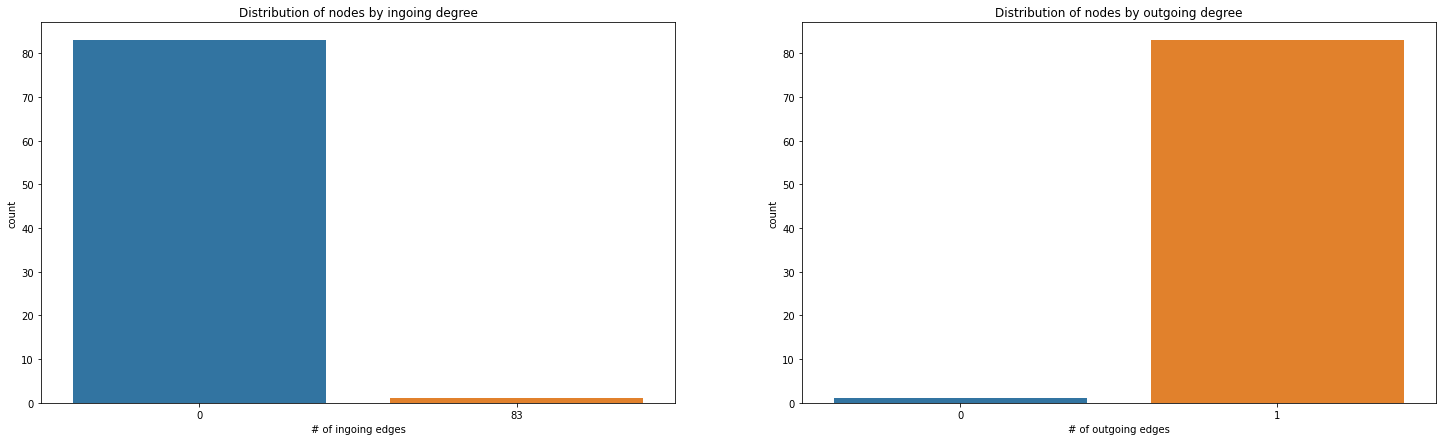

In [10]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(25,7)


sns.countplot(list(dict(GCC.in_degree).values()), ax=axs[0])
axs[0].set_title("Distribution of nodes by ingoing degree")
axs[0].set_xlabel("# of ingoing edges")

sns.countplot(list(dict(GCC.out_degree).values()), ax=axs[1])
axs[1].set_title("Distribution of nodes by outgoing degree")
axs[1].set_xlabel("# of outgoing edges")

In [11]:
# We convert to an undirected network
undirected_G = GCC.to_undirected()

# We remove self-loops 
undirected_G.remove_edges_from(nx.selfloop_edges(undirected_G))

In [12]:
characters = list(df['index'])
categories = list(df['Category'])
characters_categories_dict = dict(zip(characters, categories))

nx.set_node_attributes(GCC, characters_categories_dict, "Category")


In [13]:
print([(x,y) for x,y in GCC.nodes(data=True)][:5])

[('Mr. Flax', {'Category': 'Family_members'}), ('Billy Merchant', {'Category': 'Other'}), ('Hank Doyle', {'Category': 'Dunder_Mifflin_employees'}), ('Jack', {'Category': 'Other'}), ('Diane Kelly', {'Category': 'Dunder_Mifflin_employees'})]


In [14]:
# We define a color map for the roles
color_map = {'Main_Characters':'blue', 'Warehouse_worker':'black', 'Former_employees':'purple', 'Family_members':'red', "Other":'black', "Dunder_Mifflin_employees":"green", "Animals":"black", "Characters_of_Michael_Scott":"black", "Threat_Level_Midnight_Characters":"black", "Characters_of_Dwight_Schrute":"black", "The_3rd_Floor_Characters":"black", "Unseen_Characters":"black", "Unnamed":"black"}

In [15]:
colors = [color_map[undirected_G.nodes(data=True)[node]['Category']] for node in undirected_G.nodes() if node != "Mentioned characters"]

KeyError: 'Category'

In [16]:
# We run Force Atlas 2 to get positions for the nodes

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1.0,

    # Log
    verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(undirected_G, pos=None, iterations=5000)

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2238.98it/s]

BarnesHut Approximation  took  0.42  seconds
Repulsion forces  took  1.53  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.13  seconds


NameError: name 'colors' is not defined

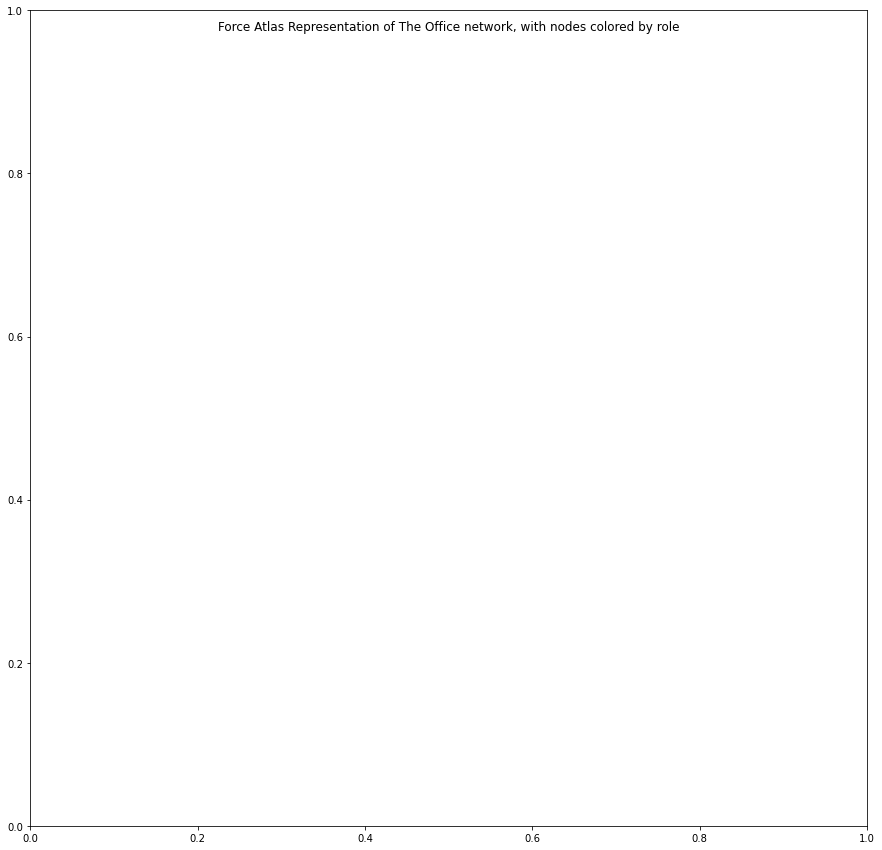

In [17]:
plt.figure(figsize=(15, 15))
plt.title("Force Atlas Representation of The Office network, with nodes colored by role", c='black',  y=1.0, pad=-20)
d = dict(undirected_G.degree)
nx.draw_networkx(undirected_G, positions, nodelist=list(d.keys()), node_size=[v*5 for v in d.values()], node_color = colors, with_labels=False, edge_color='grey')